In [1]:
!pip install segmentation-models-pytorch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
class BMPSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.bmp')])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.bmp')])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = np.array(image).transpose(2, 0, 1) / 255.0
        mask = np.array(mask)[np.newaxis, :, :] / 255.0

        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask


In [7]:
train_image_dir = '/content/drive/MyDrive/Dataset/Solar/images'
train_mask_dir  = '/content/drive/MyDrive/Dataset/Solar/labels'

train_dataset = BMPSegmentationDataset(train_image_dir, train_mask_dir)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


In [8]:
model = smp.PSPNet(encoder_name='resnet18', encoder_weights='imagenet', classes=1, activation=None)
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

In [9]:
from torchvision import transforms

class BMPSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.bmp')])
        self.mask_filenames = sorted([f for f in os.listdir(mask_dir) if f.endswith('.bmp')])
        self.image_size = image_size  # e.g. (256, 256)

        # Resize transform
        self.resize_image = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),  # Automatically converts to [0,1] and [C,H,W]
        ])
        self.resize_mask = transforms.Compose([
            transforms.Resize(self.image_size),
            transforms.ToTensor(),  # Converts to [1,H,W]
        ])

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        image = self.resize_image(image)
        mask = self.resize_mask(mask)

        return image, mask


In [10]:
train_dataset = BMPSegmentationDataset(train_image_dir, train_mask_dir, image_size=(256, 256))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)


Epoch [1/50], Loss: 0.0873
Epoch [2/50], Loss: 0.0687
Epoch [3/50], Loss: 0.0724
Epoch [4/50], Loss: 0.0687
Epoch [5/50], Loss: 0.0601
Epoch [6/50], Loss: 0.0672
Epoch [7/50], Loss: 0.0649
Epoch [8/50], Loss: 0.0649
Epoch [9/50], Loss: 0.0577
Epoch [10/50], Loss: 0.0599
Epoch [11/50], Loss: 0.0677
Epoch [12/50], Loss: 0.0684
Epoch [13/50], Loss: 0.0536
Epoch [14/50], Loss: 0.0631
Epoch [15/50], Loss: 0.0506
Epoch [16/50], Loss: 0.0623
Epoch [17/50], Loss: 0.0517
Epoch [18/50], Loss: 0.0471
Epoch [19/50], Loss: 0.0469
Epoch [20/50], Loss: 0.0468
Epoch [21/50], Loss: 0.0451
Epoch [22/50], Loss: 0.0450
Epoch [23/50], Loss: 0.0492
Epoch [24/50], Loss: 0.0460
Epoch [25/50], Loss: 0.0434
Epoch [26/50], Loss: 0.0440
Epoch [27/50], Loss: 0.0415
Epoch [28/50], Loss: 0.0398
Epoch [29/50], Loss: 0.0408
Epoch [30/50], Loss: 0.0415
Epoch [31/50], Loss: 0.0395
Epoch [32/50], Loss: 0.0498
Epoch [33/50], Loss: 0.0459
Epoch [34/50], Loss: 0.0397
Epoch [35/50], Loss: 0.0442
Epoch [36/50], Loss: 0.0391
E

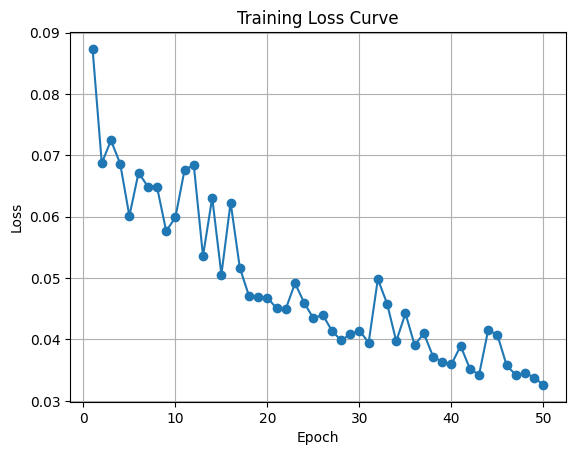

In [12]:
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.grid(True)
plt.show()


In [13]:
torch.save(model.state_dict(), 'pspnet_solar_model.pth')
print("Model saved as 'pspnet_solar_model.pth'")


Model saved as 'pspnet_solar_model.pth'


In [14]:
model.load_state_dict(torch.load('pspnet_solar_model.pth'))
model.eval()


PSPNet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
torch.save(model.state_dict(), '/content/pspnet_solar_model.pth')


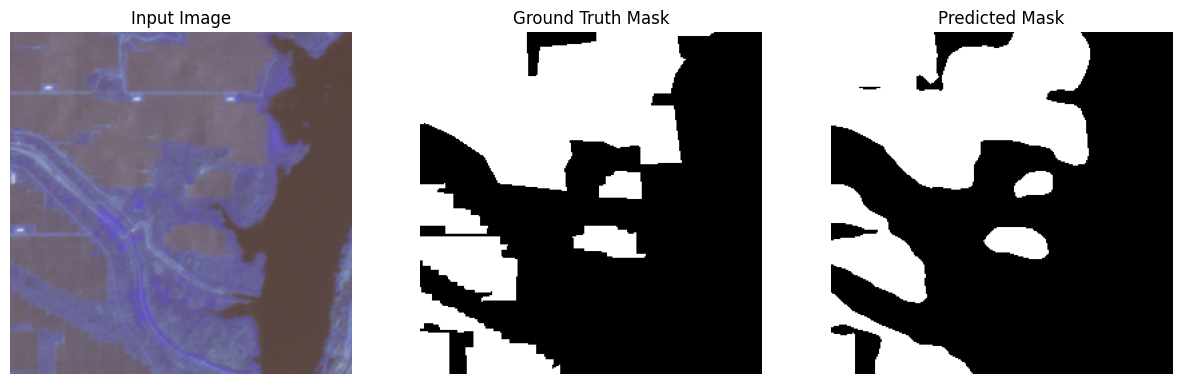

In [17]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_img, sample_mask = train_dataset[22]
    input_tensor = sample_img.unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_img.permute(1, 2, 0))  # [C,H,W] → [H,W,C]
axs[0].set_title('Input Image')
axs[1].imshow(sample_mask.squeeze(), cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred_mask_bin, cmap='gray')
axs[2].set_title('Predicted Mask')
for ax in axs:
    ax.axis('off')
plt.show()


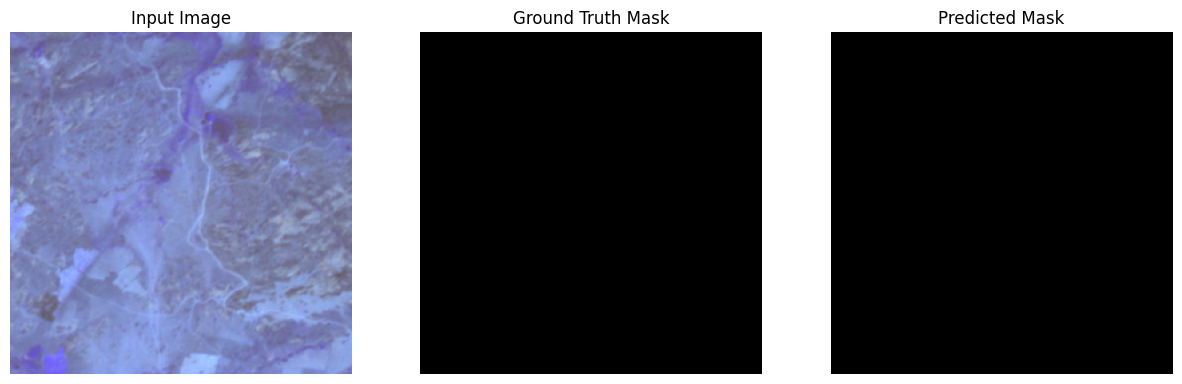

In [18]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = train_dataset[15]
    input_tensor = sample_img.unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_img.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(sample_mask.squeeze(), cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred_mask_bin, cmap='gray')
axs[2].set_title('Predicted Mask')
for ax in axs:
    ax.axis('off')
plt.show()

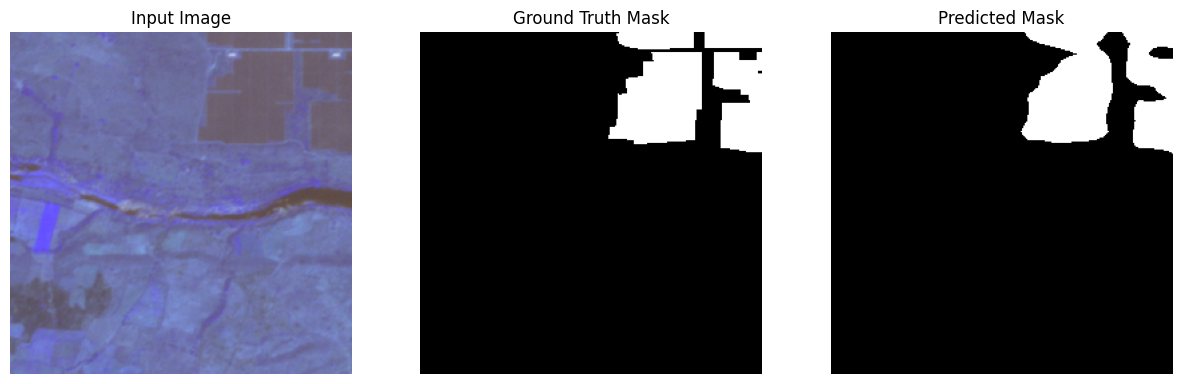

In [19]:
model.eval()
with torch.no_grad():
    sample_img, sample_mask = train_dataset[32]
    input_tensor = sample_img.unsqueeze(0).to(device)

    output = model(input_tensor)
    pred_mask = torch.sigmoid(output).squeeze().cpu().numpy()

    pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(sample_img.permute(1, 2, 0))
axs[0].set_title('Input Image')
axs[1].imshow(sample_mask.squeeze(), cmap='gray')
axs[1].set_title('Ground Truth Mask')
axs[2].imshow(pred_mask_bin, cmap='gray')
axs[2].set_title('Predicted Mask')
for ax in axs:
    ax.axis('off')
plt.show()
